# ECBD_PD_proyecto

## Preprocesado de datos

### Descripción de los datos

El proyecto de datos utiliza un conjunto de datos extraído de Kaggle en esta [referencia](https://www.kaggle.com/datasets/shivam2503/diamonds). Este conjunto de datos contiene información sobre diferentes características de diamantes, como puedan ser sus quilates (_carats_), su color (_color_) o su precio en _US dollars_ (_price_).

Con este conjunto de datos se busca realizar un modelo de aprendizaje automático que sea capaz de estimar el precio de un diamante acorde a sus características.

Las características en cuestión son las siguientes:

| Campo | Descripción |
|--------|--------|
| `price` | Precio en _US dollars_ ($326 - $18.823) |
|`carat` ([quilate](https://es.wikipedia.org/wiki/Quilate))| Peso del diamante (0,2 - 5,01)|
|`cut`|Calidad del corte del diamante. En orden ascendente: _Fair_, _Good_, _Very Good_, _Premium_, _Ideal_|
|`color`|Color del diamante, de J (peor) a D (mejor)|
|`clarity`| Medida de claridad del diamante. En orden ascendente: _I1_, _SI2_, _SI1_, _VS2_, _VS1_, _VVS2_, _VVS1_, _IF_|
|`x`| Largo en _mm_ (0 - 10,74)|
|`y`| Ancho en _mm_ (0 - 58,9)|
|`z`| Profundidad en _mm_ (0 - 31,8)|
|`depth`| Porcentaje de profundida del diamante respecto a su tamaño ($depth =  2 \cdot \frac{z}{x + y}$) (43 - 79)|
|`table`| Anchura del extremo del diamante respecto al punto más distante (43 - 95)|

En este caso, la característica objetivo que se busca estimar es el precio del diamante (`price`), por lo que debemos construir los modelos de aprendizaje con esta característica en mente.

In [2]:
import pandas as pd

df = pd.read_csv("../data/diamonds.csv").drop(columns="Unnamed: 0")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
print(df.size)

539400


### Análisis previo de los datos

#### Analítica de datos faltantes

Comenzamos por analizar los campos del dataset en busca de registros con valores faltantes o nulo. 

In [3]:
pd.DataFrame(
    data = df.isna().sum(),
    columns = ["Valores faltantes"]
)

,Valores faltantes
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


Aparentemente no existen valores faltantes o nulos en nuestro conjunto de datos.

#### Analítica de atributos redundantes

Para analizar una posible redundancia entre atributos, calcularemos la correlación entre ellos utilizando diferentes métodos. Estos métodos son:

* Correlación de Pearson
* Correlación de Spearman

Comenzaremos por graficar las posibles combinaciones de variables:

[]

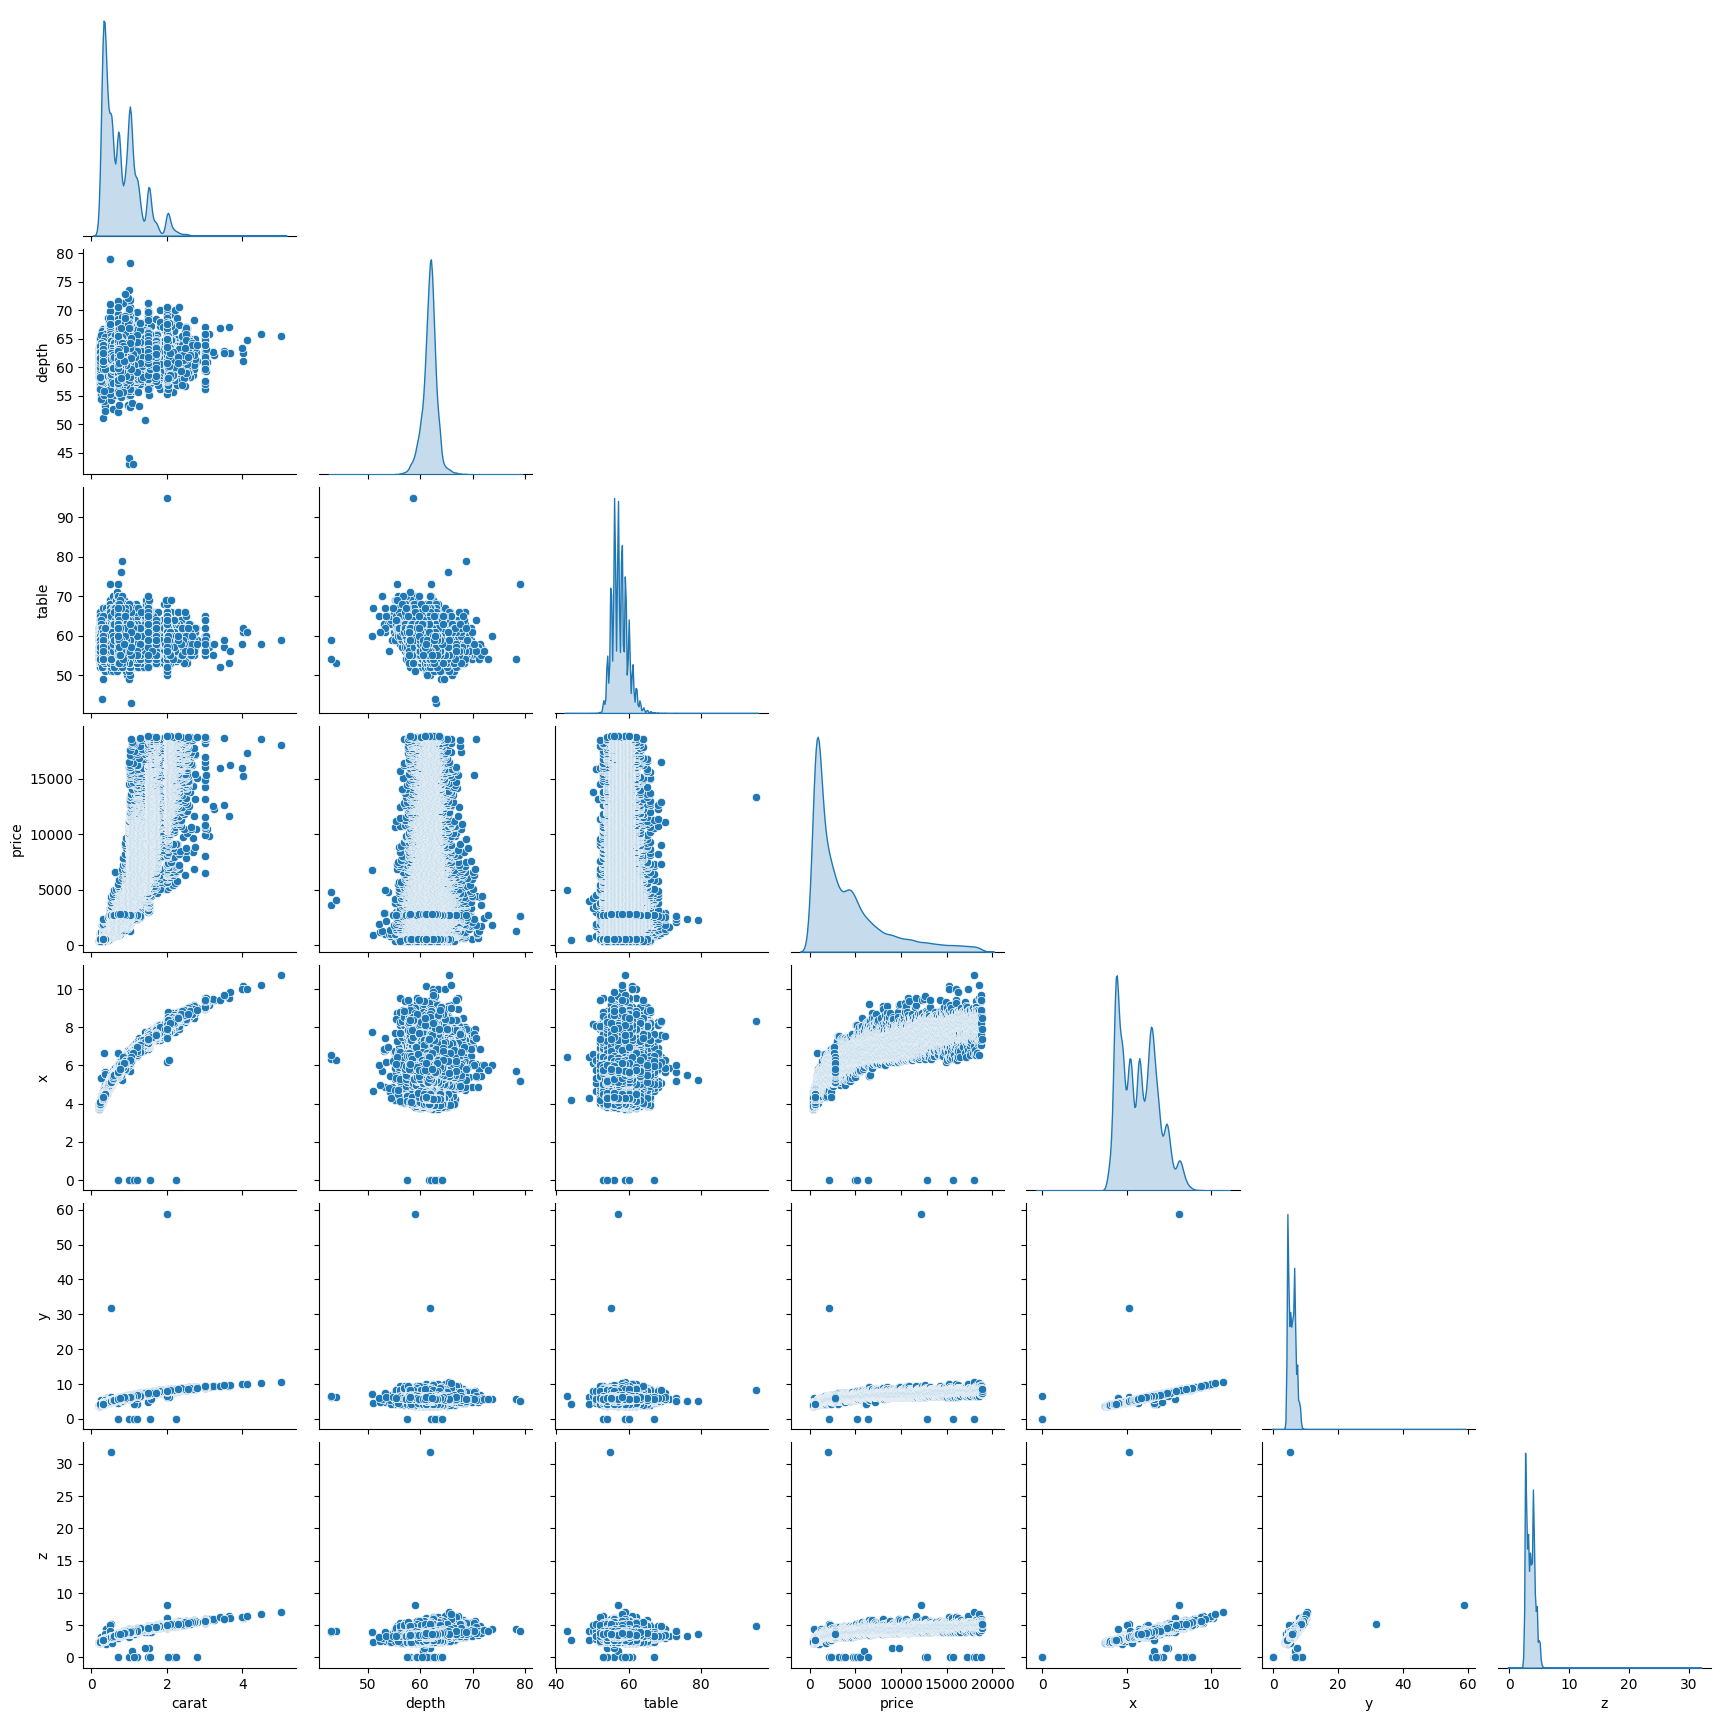

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

sns.pairplot(
    data = df[numeric_columns],
    corner = True,
    diag_kind = "kde"
)
plt.plot()

Podemos observar cómo existen a simple vista variables altamente relacionadas, como puedan ser los pares [`z`, `carat`], [`y`, `x`] y [`z`, `price`]. También podemos observar variables con poca relación aparente lineal entre sí, como puedan ser los pares [`z`, `depth`] o [`x`, `table`].

Ejecutando sobre estas variables los coeficientes de _Pearson_ y _Spearman_, obtenemos los siguientes valores:

<Axes: >

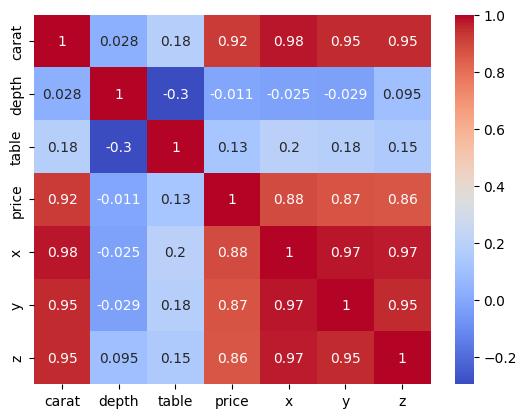

In [19]:
sns.heatmap(
    data = df.corr(method = "pearson", numeric_only=True),
    annot = True,
    cmap = "coolwarm"
)

#### Analítica de duplicidad de registros

### Corrección de atributos redundantes

### Corrección de duplicidad de registros

### Normalización de datos

## Extracción de conocimiento